In [28]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networks import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score,multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCELoss
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
emb = pd.read_pickle(os.path.join(Path.cwd().parent,'data','stackexchange_reduced_tags_embeddings.pkl'))

In [4]:
emb.head(2)

,title_embedding,question_text_embedding,tags
question_id,,,
79802517,"[0.008553513, -0.009437113, 0.009673767, -0.02...","[0.0013518566, -0.015674047, -0.004076924, -0....","[.net, entity-framework]"
79802934,"[0.019479005, 0.007850029, -0.020600174, -0.02...","[0.009473968, -0.014583107, -0.019139914, 0.00...",[datetime]


In [5]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(emb['tags'])

In [6]:
title_embeddings = np.vstack(emb['title_embedding'].values)
body_embeddings = np.vstack(emb['question_text_embedding'].values)
num_tags = emb['tags'].apply(len).values.reshape(-1)
indices = emb.index.tolist()

In [7]:
train_dataset = StackOverflowDataset(
    title_embeddings=title_embeddings,
    body_embeddings=body_embeddings,
    num_tags_list=num_tags,
    binary_labels=y,
    train=True,
)
val_dataset = StackOverflowDataset(
    title_embeddings=title_embeddings,
    body_embeddings=body_embeddings,
    num_tags_list=num_tags,
    binary_labels=y,
    train=False,
)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [36]:
model = DSF_MHSA_Classifier(
    input_dim=4096, 
    hidden_dim=1024, 
    num_classes=100,
    dropout=0.5
).to(device)

In [ ]:
criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=1)
# Because of this gamma_neg =4, the model is heavily penalized for false positives—hence the high recall.
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [38]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Progress bar for training
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for t_emb, b_emb, n_tags, labels in train_bar:
        # Move data to GPU
        t_emb = t_emb.to(device)
        b_emb = b_emb.to(device)
        n_tags = n_tags.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward pass
        logits = model(t_emb, b_emb, n_tags)
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = running_loss / len(train_loader)
    
    # --- Validation ---
    model.eval()
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for t_emb, b_emb, n_tags, labels in val_loader:
            t_emb = t_emb.to(device)
            b_emb = b_emb.to(device)
            n_tags = n_tags.to(device)
            labels = labels.cpu().numpy()
            
            logits = model(t_emb, b_emb, n_tags)
            
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            val_targets.append(labels)
            val_preds.append(preds)
            
    # Concatenate all batches
    val_targets = np.vstack(val_targets)
    val_preds = np.vstack(val_preds)
    
    # Calculate F1 Score (Micro is usually preferred for global performance)
    val_f1_micro = f1_score(val_targets, val_preds, average='micro')
    val_f1_macro = f1_score(val_targets, val_preds, average='macro')
    
    print(f"Epoch {epoch+1} Results:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val F1 (Micro): {val_f1_micro:.4f}")
    print(f"  Val F1 (Macro): {val_f1_macro:.4f}")
    
    # Step scheduler based on F1 score
    scheduler.step(val_f1_micro)

In [19]:
def plot_classification_report(y_true, y_pred, mlb):
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=mlb.classes_, 
        output_dict=True
    )
    
    df_report = pd.DataFrame(report).transpose()
    
    df_classes = df_report.iloc[:-4]  
    
    plt.figure(figsize=(10, len(mlb.classes_) * 0.3))
    sns.heatmap(df_classes[['precision', 'recall', 'f1-score']], 
                annot=True, 
                cmap='viridis', 
                fmt='.2f')
    plt.title("Per-Tag Performance")
    plt.show()

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


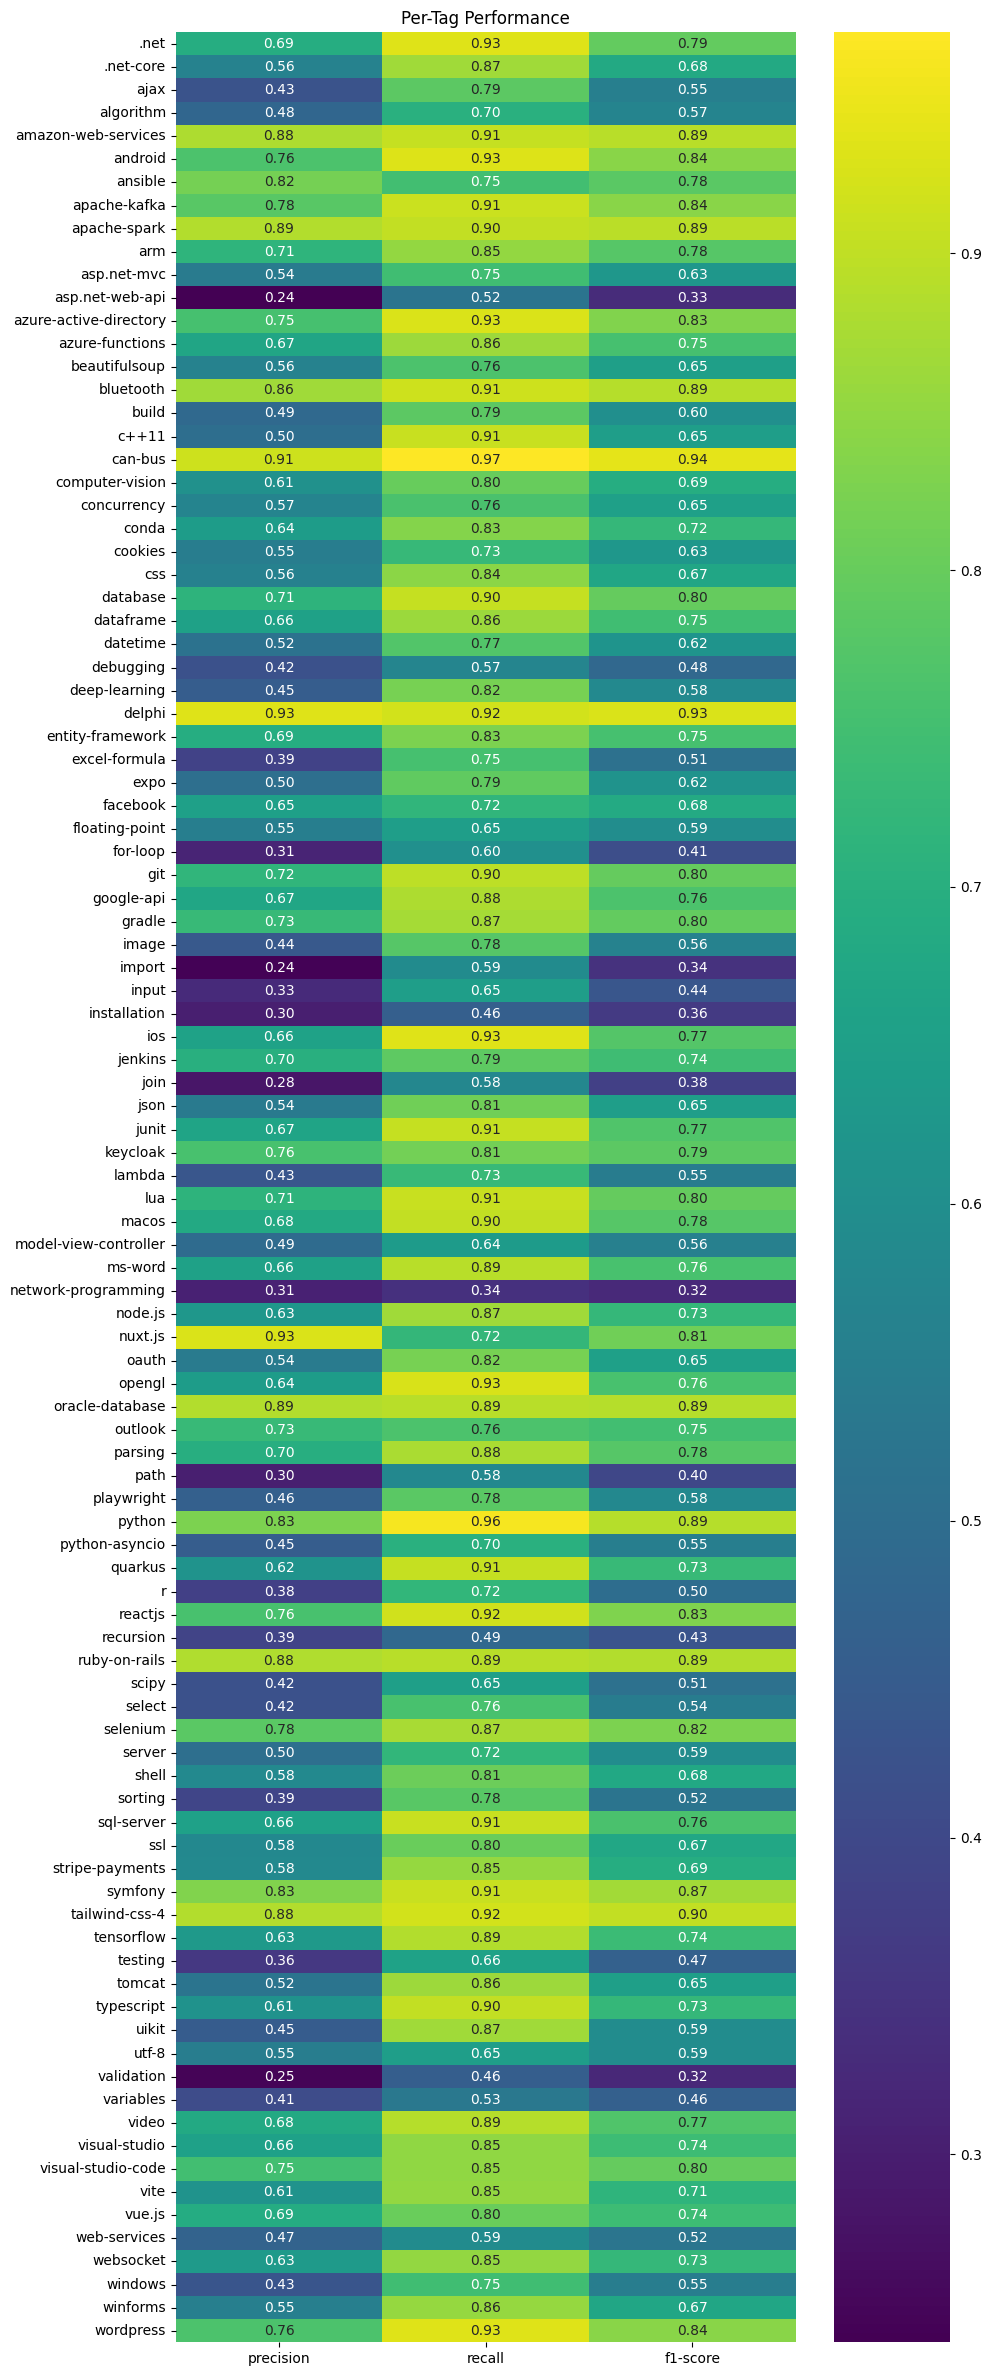

In [20]:
plot_classification_report(val_targets, val_preds, mlb)

In [21]:
import plotly.graph_objects as go

In [33]:
import plotly.subplots as sp

def plot_interactive_confusion_matrix(cm, class_names=None):
    """
    Create an interactive confusion matrix using Plotly for multilabel classification.
    
    Parameters:
    - cm: multilabel confusion matrix (shape: n_classes, 2, 2)
    - class_names: list of class names (optional)
    """
    n_classes = cm.shape[0]
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Calculate subplot grid
    rows = int(np.ceil(np.sqrt(n_classes)))
    cols = int(np.ceil(n_classes / rows))
    
    fig = sp.make_subplots(
        rows=rows, 
        cols=cols, 
        subplot_titles=class_names[:n_classes],  # Limit to n_classes
        horizontal_spacing=0.05,
        vertical_spacing=0.05
    )
    
    for i in range(n_classes):
        cm_i = cm[i]
        
        # Normalize by row (show percentages)
        cm_normalized = cm_i.astype('float') / cm_i.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
        
        # Create hover text with both counts and percentages
        hover_text = []
        for p in range(2):
            hover_row = []
            for q in range(2):
                hover_row.append(
                    f"True: {['Negative', 'Positive'][p]}<br>"
                    f"Pred: {['Negative', 'Positive'][q]}<br>"
                    f"Count: {cm_i[p, q]}<br>"
                    f"Percentage: {cm_normalized[p, q]*100:.1f}%"
                )
            hover_text.append(hover_row)
        
        # Add heatmap to subplot
        fig.add_trace(
            go.Heatmap(
                z=cm_normalized,
                x=['Predicted Negative', 'Predicted Positive'],
                y=['True Negative', 'True Positive'],
                hovertext=hover_text,
                hoverinfo='text',
                colorscale='Blues',
                showscale=(i == 0),  # Show colorbar only for the first subplot
                colorbar=dict(title="Percentage") if i == 0 else None
            ),
            row=i // cols + 1,
            col=i % cols + 1
        )
    
    fig.update_layout(
        title='Multilabel Confusion Matrices (Normalized by Row)',
        width=cols * 200,  # Adjust width based on cols
        height=rows * 200,  # Adjust height based on rows
    )
    
    return fig

In [30]:
cm = multilabel_confusion_matrix(val_targets, val_preds)

In [34]:
fig = plot_interactive_confusion_matrix(cm,mlb.classes_)
fig.show()